In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold

In [2]:
# train and test data
train_data=pd.read_csv(r'C:\Users\User\Desktop\ms\model selection\train.csv')

In [3]:
train_data.shape

(76020, 371)

In [4]:
y=train_data.iloc[:,-1]
x=train_data.iloc[:,:-1]

In [5]:
# train_test split of data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
X_train.shape,X_test.shape

((60816, 370), (15204, 370))

# Basic method

In [7]:
#removing constant feature
constant_filter=VarianceThreshold(threshold=0)
constant_filter.fit(X_train)

constant_list=[not temp for temp in constant_filter.get_support()]

X_train_filter=constant_filter.transform(X_train)

X_test_filter=constant_filter.transform(X_test)

In [8]:
#QUASI CONSTANT FEATURE REMOVAL

qconst_filter=VarianceThreshold(threshold=.01)
qconst_filter.fit(X_test_filter)

X_train_quasi_filter=qconst_filter.transform(X_train_filter)

X_test_quasi_filter=qconst_filter.transform(X_test_filter)


In [9]:
# DUPLICATE FEATURE REMOVING

X_train_T=X_train_quasi_filter.T
X_test_T=X_test_quasi_filter.T

X_train_T=pd.DataFrame(X_train_T)
X_test_T=pd.DataFrame(X_test_T)

duplicated_feature=X_train_T.duplicated()

feature_to_keep=[not index for index in duplicated_feature]

X_train_unique=pd.DataFrame(X_train_T[feature_to_keep].T)

X_test_unique=pd.DataFrame(X_test_T[feature_to_keep].T)

In [10]:
X_train_unique.shape,X_test_unique.shape

((60816, 234), (15204, 234))

# MUTUAL INFORMATION GAIN method

# CLASSIFICATION PROBELM

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest,SelectPercentile

In [13]:
mi=mutual_info_classif(X_train_unique,y_train)

In [15]:
mi=pd.Series(mi)
mi.index=X_train_unique.columns

In [16]:
mi.sort_values(ascending=False,inplace=True)

In [17]:
mi

42     0.017904
53     0.017582
88     0.017108
103    0.016737
184    0.016454
         ...   
79     0.000000
80     0.000000
81     0.000000
82     0.000000
124    0.000000
Length: 234, dtype: float64

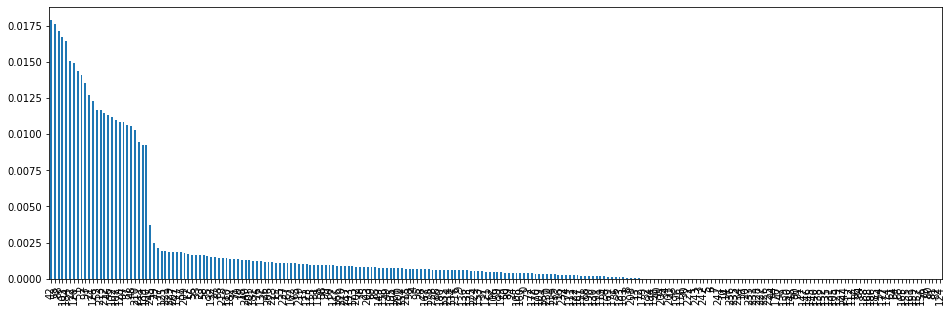

In [20]:
mi.plot.bar(figsize=(16,5))

In [21]:
select=SelectPercentile(mutual_info_classif,percentile=10)
select.fit(X_train_unique,y_train)

SelectPercentile(percentile=10,
                 score_func=<function mutual_info_classif at 0x0000000C554BCA68>)

In [28]:
X_train_unique.columns[select.get_support()]

Int64Index([  2,  21,  22,  42,  46,  48,  51,  52,  53,  87,  88,  93,  97,
            100, 102, 103, 120, 126, 128, 184, 189, 210, 212, 213],
           dtype='int64')

In [29]:
X_train_mi=select.transform(X_train_unique)

X_test_mi=select.transform(X_test_unique)

In [30]:
X_train_mi.shape,X_test_mi.shape

((60816, 24), (15204, 24))

In [ ]:
# model evalution

In [31]:
def run_RandomForest(X_train,X_test,y_train,y_test):
    rf=RandomForestClassifier(n_estimators=100,random_state=42)
    rf.fit(X_train,y_train)
    pred=rf.predict(X_test)
    print("accuracy of model:",accuracy_score(y_test,pred))

In [32]:
%%time
run_RandomForest(X_train_unique,X_test_unique,y_train,y_test)

accuracy of model: 0.9558668771375953
Wall time: 46.2 s


In [33]:
%%time
run_RandomForest(X_train_mi,X_test_mi,y_train,y_test)

accuracy of model: 0.9566561431202315
Wall time: 21.7 s


# regression problem

In [35]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [36]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest,SelectPercentile

In [37]:
boston =load_boston()

In [43]:
x=pd.DataFrame(data=boston.data,columns=boston.feature_names)

y=boston.target

In [44]:
# train_test split of data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [45]:
mi=mutual_info_regression(X_train,y_train)

In [48]:
mi=pd.Series(mi)
mi.index=X_train.columns
mi.sort_values(ascending=False,inplace=True)

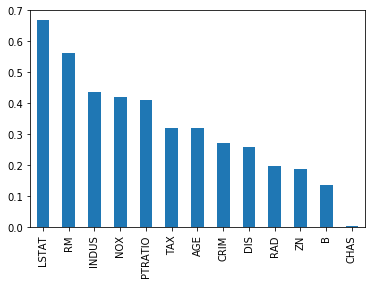

In [50]:
mi.plot.bar()

In [51]:
# select top 9
select=SelectKBest(mutual_info_regression,k=9)
select.fit(X_train,y_train)

SelectKBest(k=9,
            score_func=<function mutual_info_regression at 0x0000000C554BC9D8>)

In [52]:
X_train.columns[select.get_support()]

Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [53]:
X_train_mi=select.transform(X_train)

X_test_mi=select.transform(X_test)

In [54]:
X_train_mi.shape ,X_test_mi.shape

((404, 9), (102, 9))

In [55]:
# model evalution

In [56]:
def run_regression(X_train,X_test,y_train,y_test):
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    pred=lr.predict(X_test)
    print('r2_score',r2_score(y_test,pred))
    print('RMSE :',np.sqrt(mean_squared_error(y_test,pred)))

In [57]:
%%time
#without feature selection
run_regression(X_train,X_test,y_train,y_test)

r2_score 0.7087353695957153
RMSE : 4.493588160416785
Wall time: 1.57 s


In [58]:
%%time
# feature selected by mi gain method
run_regression(X_train_mi,X_test_mi,y_train,y_test)

r2_score 0.6722063141830374
RMSE : 4.767049742815881
Wall time: 29 ms
